# Dataset ARPAV
Registrazione delle misure recuperate dal database ARPA Veneto fornito da Maugeri.

La procedura si articola nei seguenti passaggi:
1. [caricamento dei dati grezzi](#caricamento-da-frammenti) e uniformazione negli schemi esposti sotto;
1. [primo quality check](#quality-check): controllo errori di consistenza nella singola serie e nelle coppie di serie della stessa stazione;
1. [overview disponibilità dati](#overview-disponibilità-dati): plot che mostrano la disponibilità temporale e spaziale di serie;
1. [merging](#merging) del dataset con SCIA.

## Data model
### Metadati
| station_id | station_name | network | state | lon    | lat    | elevation | dataset_id | original_id |
|------------|--------------|---------|-------|--------|--------|-----------|------------|-------------|
| utf8()     | utf8()       | utf8()  | utf8()|double()|double()| double()  | utf8()     | utf8()      |
| pkey       | obs          | obs     | obs   | obs    | obs    | obs       | fkey       | obs         |

I metadati delle stazioni che non rientrano nelle tabelle elencate vanno in una tabella "extra" collegata tramite "station_id".

### Dati
|series_id|date|value|merged|variable|
|---------|----|-----|------|--------|
|utf8()|date()|double()|bool()|utf8()|
| fkey    |obs | obs | obs  | obs    |

Note:
- `merged` indica se il valore in riga è il risultato di un merge.


In [1]:
dataset_id <- "ARPAV"
state <- "Veneto"


In [21]:
setwd(fs::path_abs("~/Local_Workspace/TesiMag"))
library(arrow, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)
library(zeallot, warn.conflicts = FALSE)
library(stringr, warn.conflicts = FALSE)
options(repr.plot.width = 9, repr.plot.res = 300)

source(str_glue("notebooks/integrazioni_regionali/{str_to_lower(state)}/procedures/load_daily.R"))
source(str_glue("notebooks/integrazioni_regionali/{str_to_lower(state)}/procedures/match_taggers.R"))
source("notebooks/integrazioni_regionali/procedure/common_steps.R")
source("notebooks/integrazioni_regionali/procedure/checkpoint.R")
source("notebooks/integrazioni_regionali/procedure/tools.R")
source("src/database/tools.R")
source("src/load/ITA.R")

first_date <- as.Date("2000-01-01")
last_date <- as.Date("2022-12-31")
state_boundaries <- load.italian_boundaries("state") |> filter(shapeName == state)


## Caricamento da frammenti
Dati giornalieri come forniti dall'ente, in formato tabella Arrow


In [3]:
daily_dataset <- load_daily_data.arpav() |> prepare_daily_data(first_date, last_date)
checkpoint_database(daily_dataset$database, dataset_id, "raw")
write_extra_metadata(daily_dataset$extra_meta, dataset_id, provisional = FALSE)
rm(daily_dataset)
gc()

,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,1742031,93.1,3286708,175.6,NA,2504178,133.8
Vcells,6025027,46.0,44680995,340.9,16384,55637040,424.5


## Quality check
Controllo gross errors, dati ripetuti, T_MIN >= T_MAX, serie intere

In [4]:
raw_database <- open_checkpoint(dataset_id, "raw")
qc_database <- qc1(raw_database, stop_on_error = TRUE)

checkpoint_database(qc_database, dataset_id, "qc1")
rm(raw_database)
rm(qc_database)
gc()

,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,1921988,102.7,3286708,175.6,NA,3286708,175.6
Vcells,6348276,48.5,61999967,473.1,16384,77492743,591.3


## Overview disponibilità dati
Grafici che mostrano la disponibilità di serie mese per mese e sul territorio

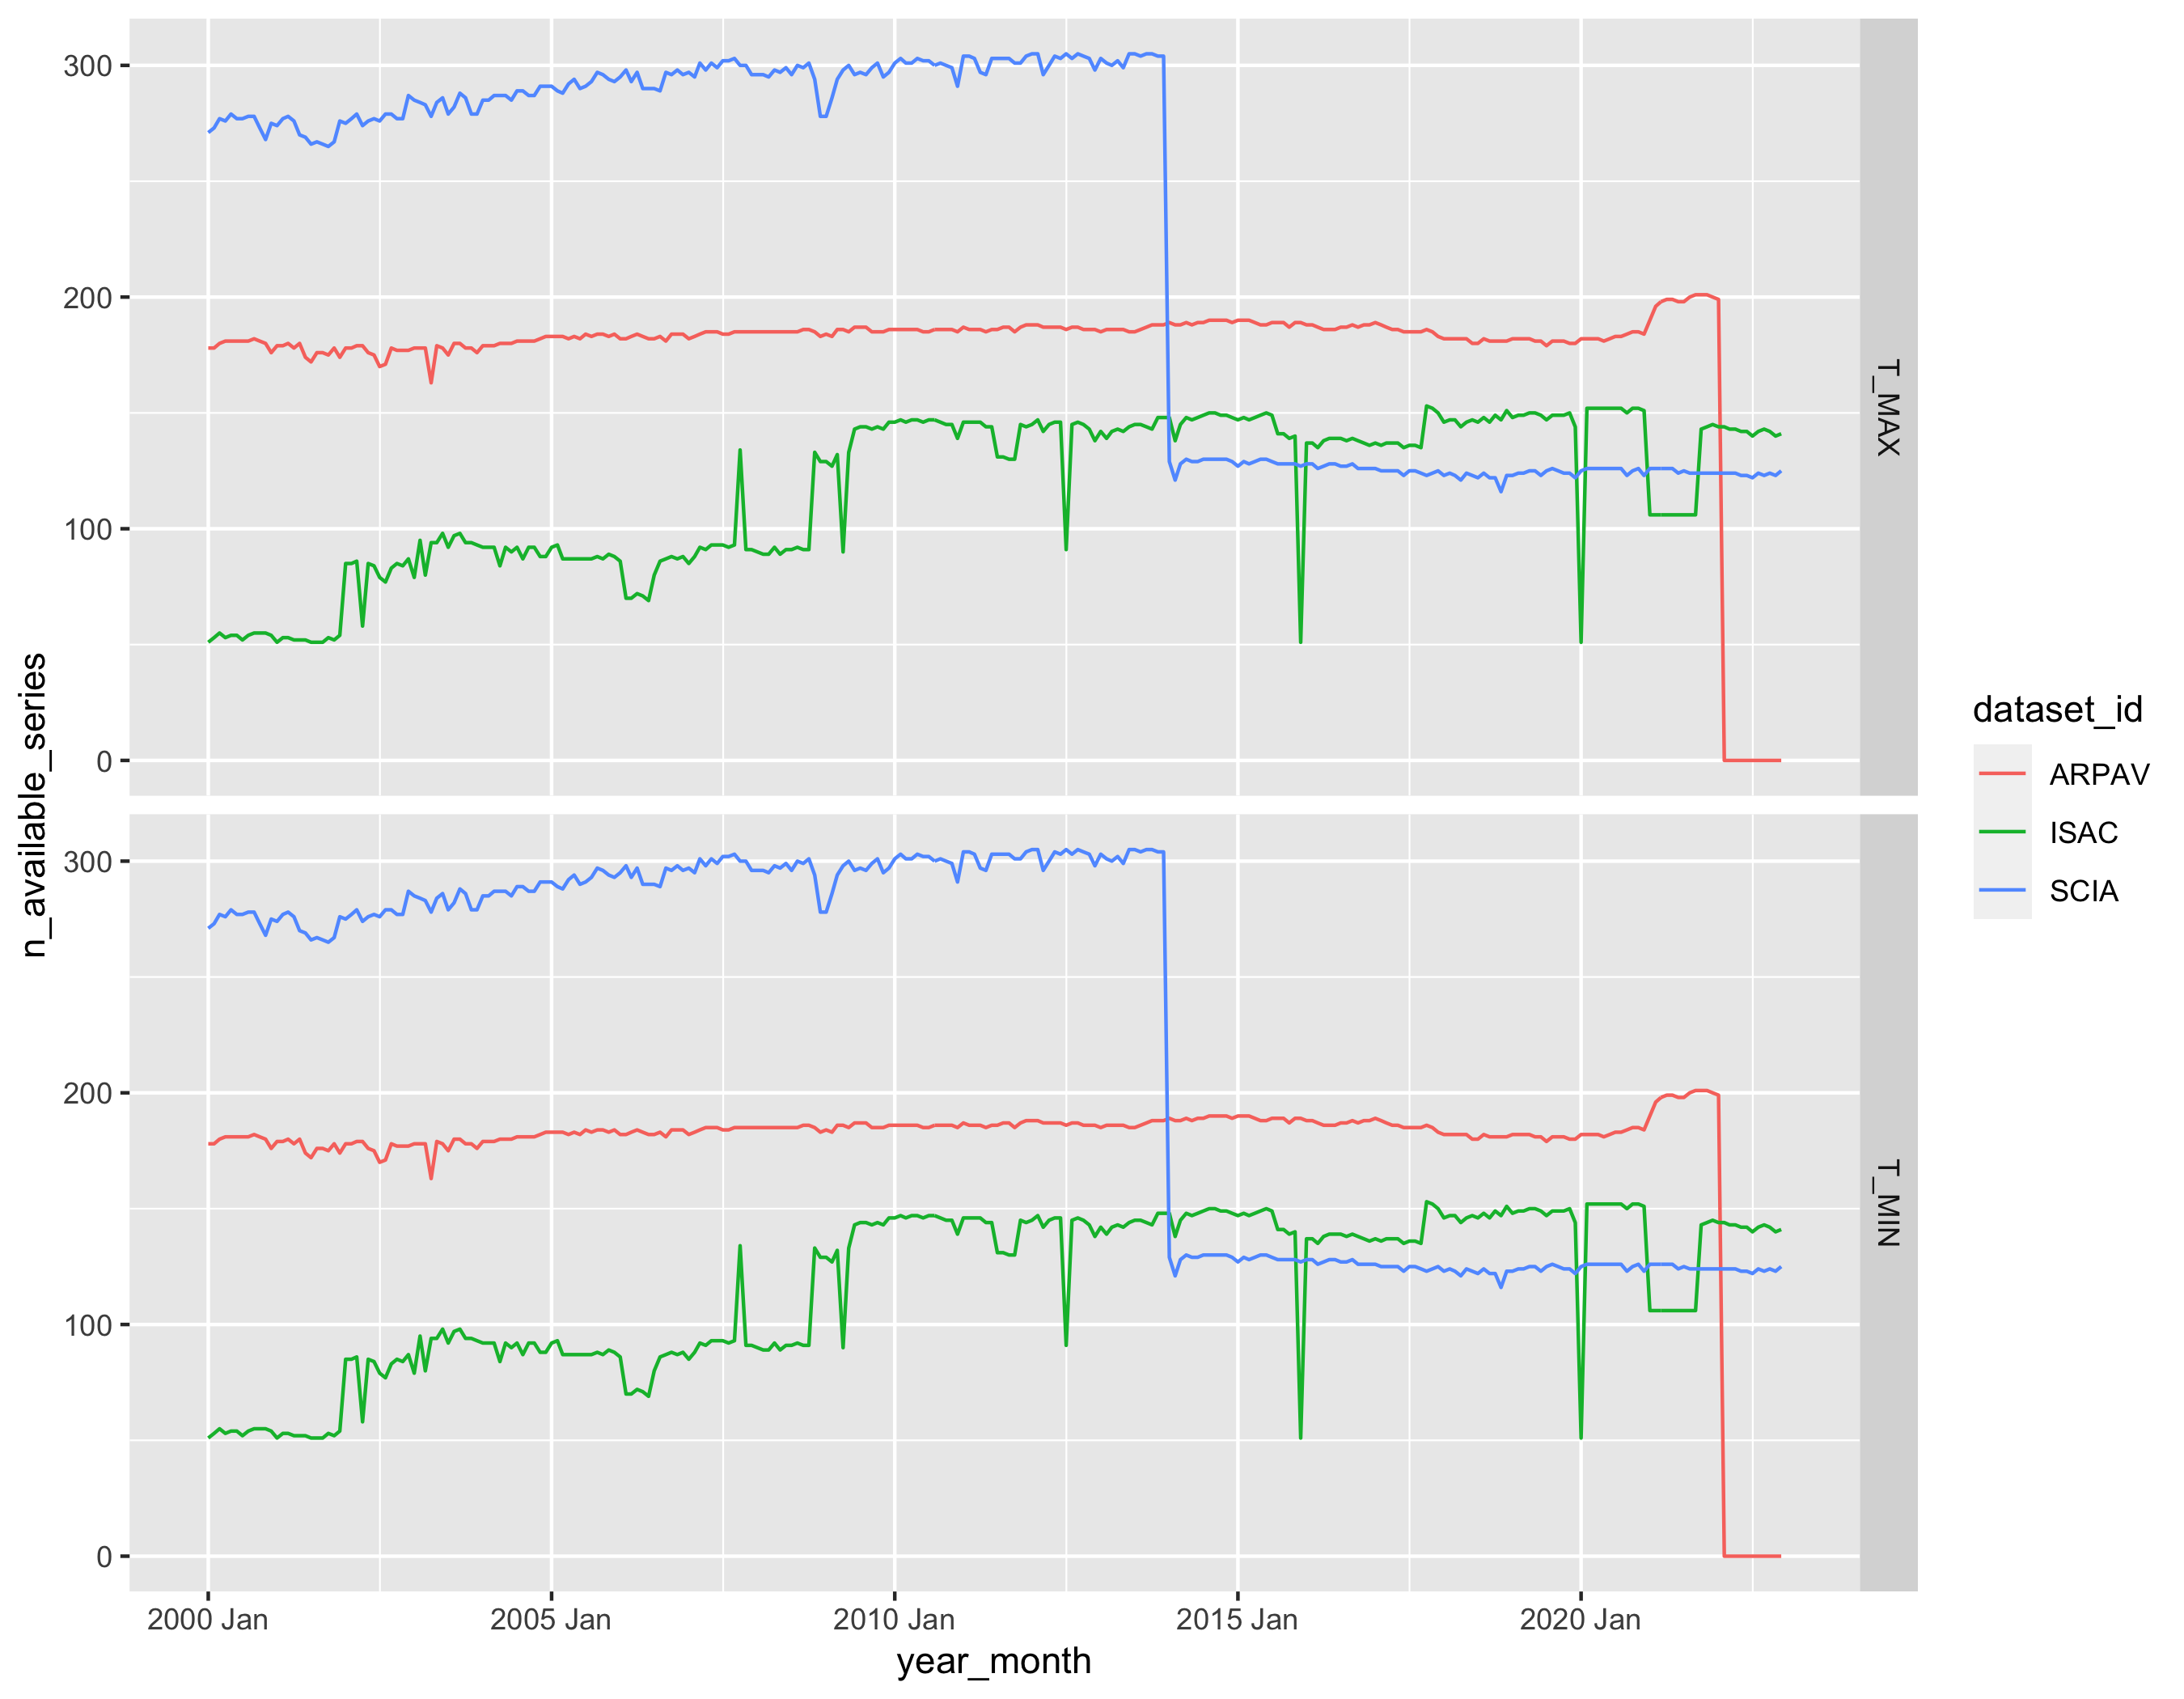

In [7]:
qc_database <- open_checkpoint(dataset_id, "qc1")
others <- concat_databases(
    open_checkpoint("SCIA", "qc1") |> filter_checkpoint_inside(state_boundaries),
    open_checkpoint("ISAC", "qc1") |> filter_checkpoint_inside(state_boundaries)
)
c(p, ymonthly_avail) %<-% ymonthly_availabilities(qc_database,
    against = others,
    region = state_boundaries,
    chkp_id = "qc1",
    start_date = first_date,
    end_date = last_date
)
p


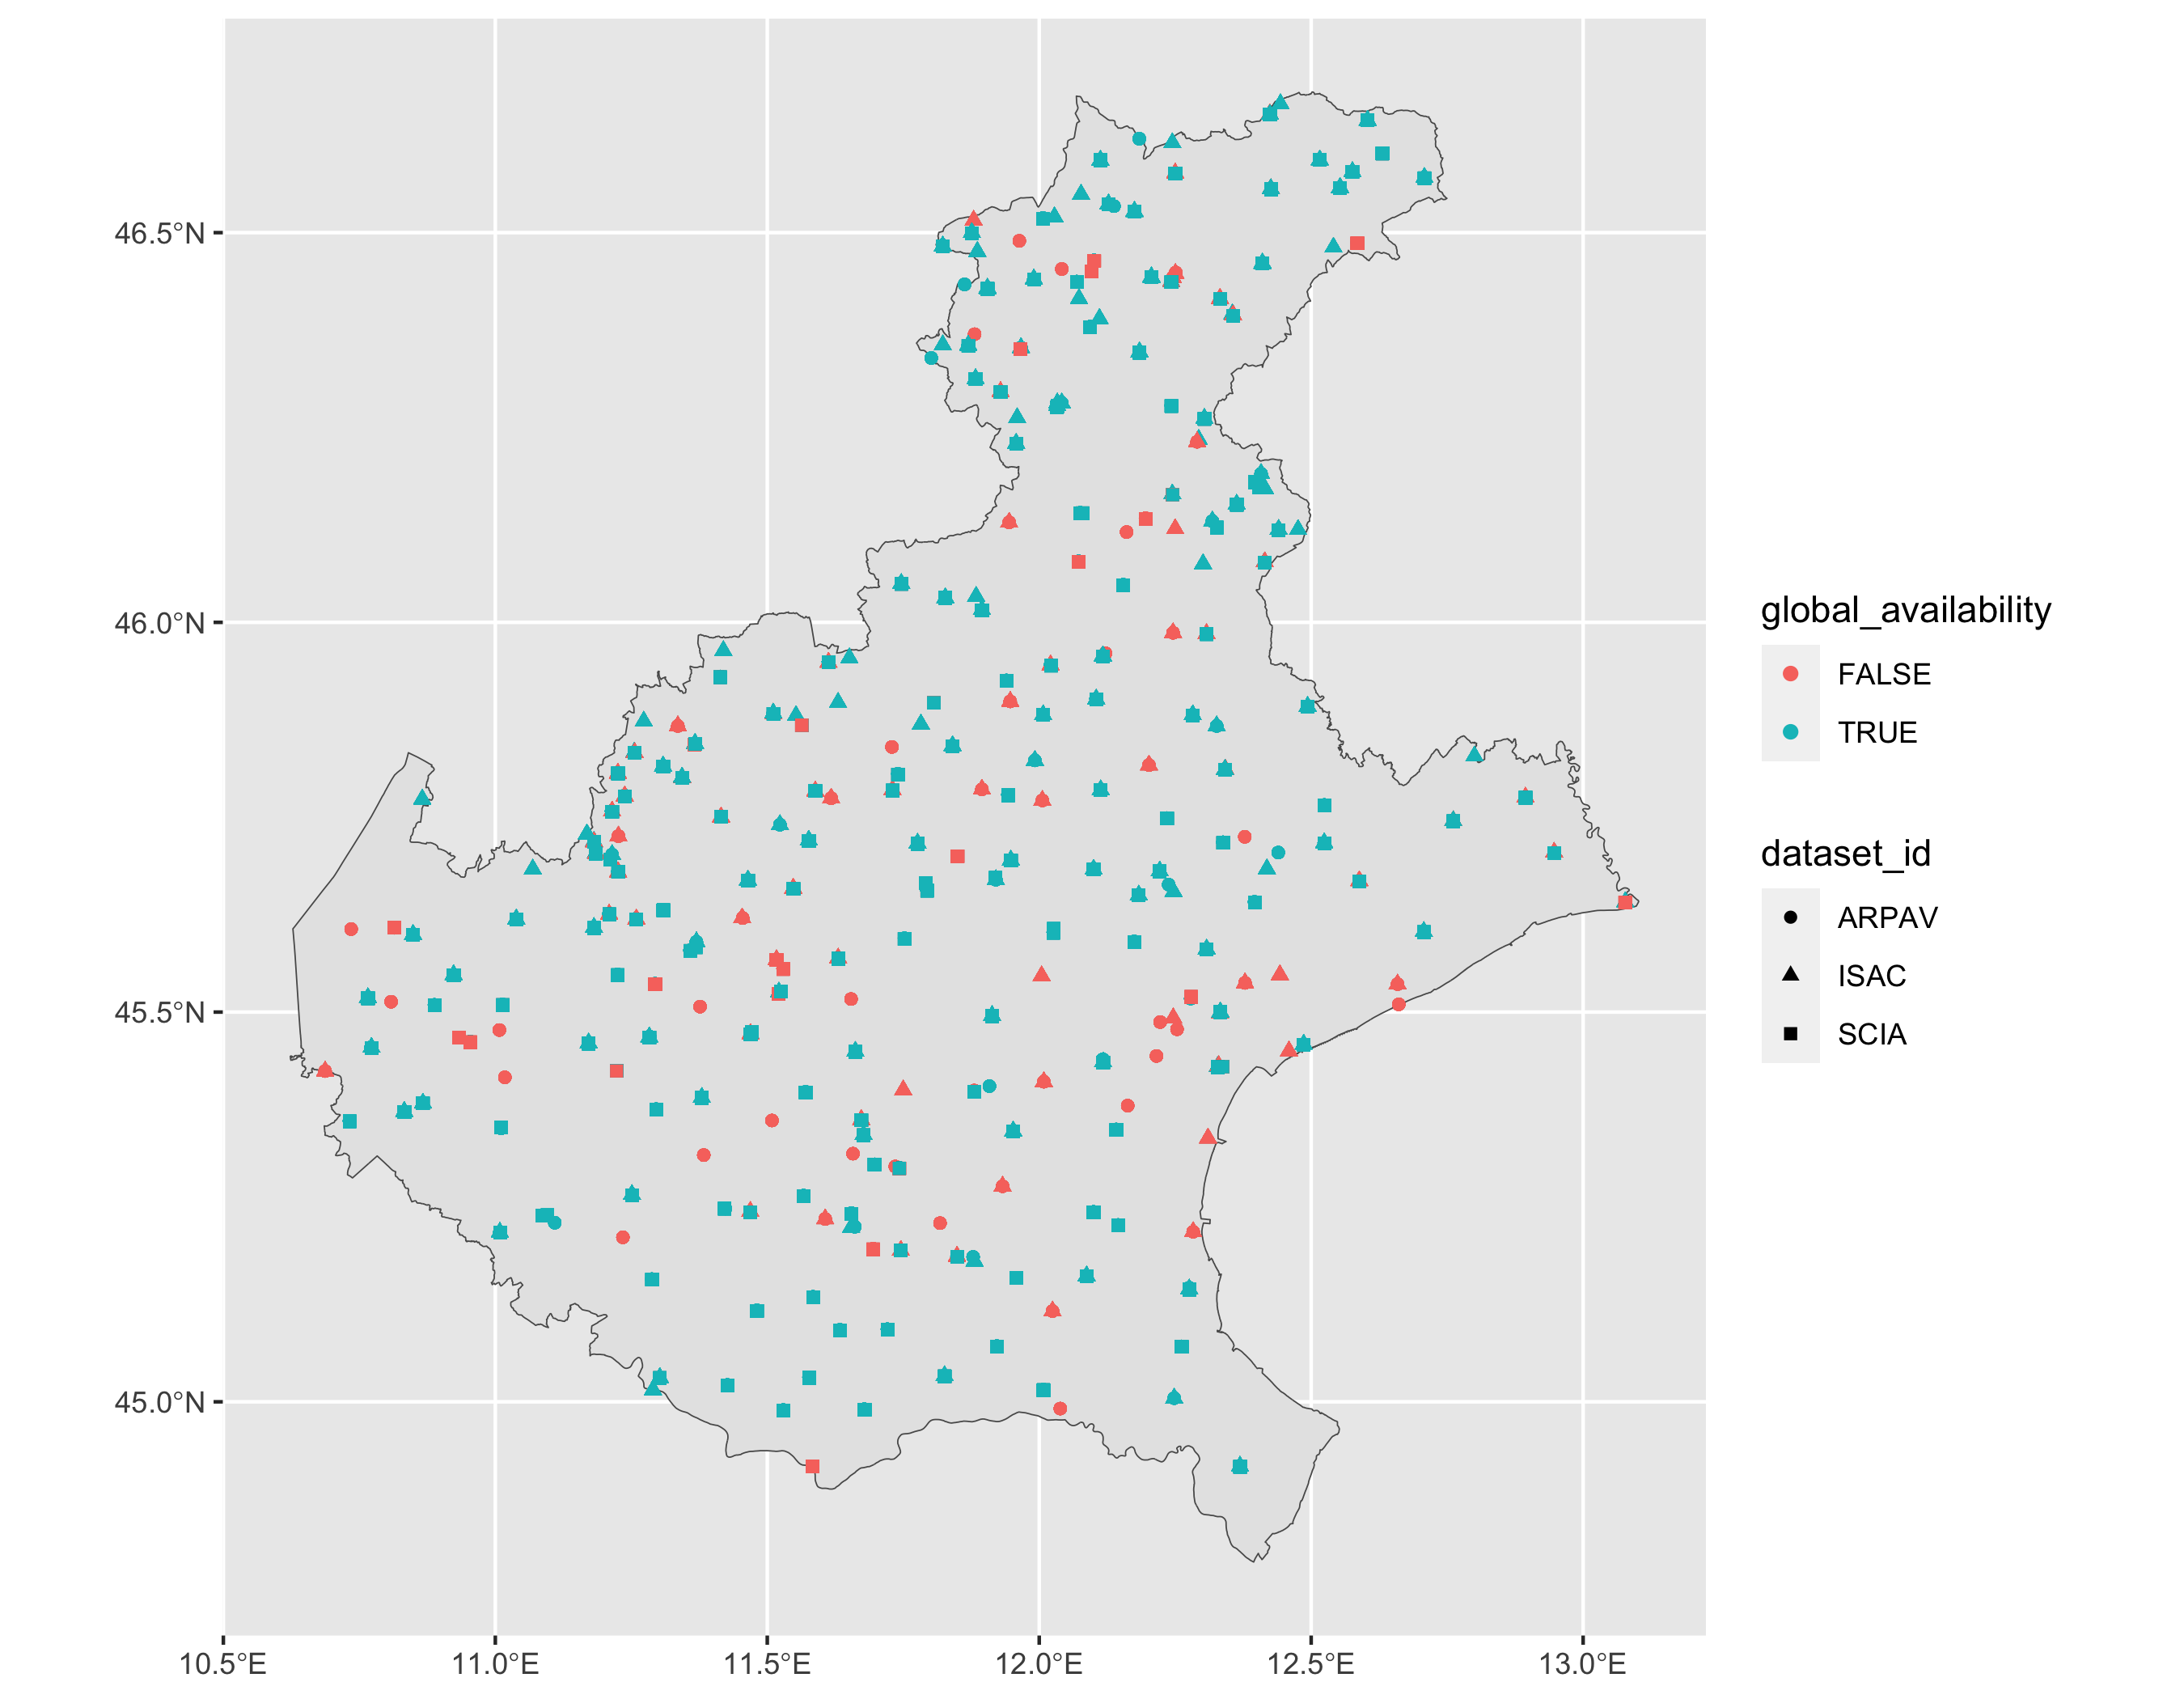

In [9]:
c(p, climats) %<-% spatial_availabilities(ymonthly_avail, concat_tables(qc_database$meta, others$meta), state_boundaries)
p


In [10]:
rm(qc_database)
rm(ymonthly_avail)
rm(climats)
rm(p)
gc()

,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2238202,119.6,6538775,349.3,NA,6538775,349.3
Vcells,6338783,48.4,376689492,2874.0,16384,470861853,3592.4


## Merging
Gap-filling con altri dataset

### Match stazioni
Partendo dal file di analisi appena scritto preparo dei filtri che categorizzino il match.

Le possibilità sono:
- `tag_same_station`: il match indica una stessa stazione;
- `tag_unusable`: il match è inutilizzabile;
- `tag_pairable`: il match indica che le stazioni sono utilizzabili per fare gap-filling.

Può essere che un match sia sulla stessa stazione ma che sia inutilizzabile; `tag_unusable` e `tag_pairable` invece si dovrebbero escludere vicendevolmente.

In [11]:
qc_arpav <- open_checkpoint(dataset_id, "qc1")
qc_scia <- open_checkpoint("SCIA", "qc1") |> filter_checkpoint_inside(state_boundaries)
analysis_results <- perform_analysis(
    qc_arpav,
    qc_scia,
    dist_km = 10,
    first_date,
    last_date,
    str_to_lower(state),
)

rm(qc_arpav)
rm(qc_scia)
gc()


Data prepared. Launching analysis...

,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2339760,125.0,6768103,361.5,NA,8460128,451.9
Vcells,16078048,122.7,642094863,4898.8,16384,802618578,6123.5


In [12]:
analysis_results <- tag_analysis(analysis_results, list("same_station" = tag_same_station, "unusable" = tag_unusable))
analysis_results$analysis |>
        group_by(same_station, unusable) |>
        tally()
filter(analysis_results$analysis, same_station) |>
        group_by(station_id.x) |>
        tally() |>
        filter(n > 4L | n < 2L)
filter(analysis_results$analysis, same_station) |>
        group_by(station_id.y) |>
        tally() |>
        filter(n != 2L)


same_station,unusable,n
<lgl>,<lgl>,<int>
FALSE,FALSE,612
FALSE,TRUE,1608
TRUE,FALSE,641
TRUE,TRUE,27


station_id.x,n
<chr>,<int>
6686b31c6bcebee8e9494e14ffc68fb0,6
7f87b887e813f38be09a56b94d803e6b,6
8f13a8f8ac966a3dc3bd9d40a01a985b,6
bf571cea11657b13df57c8c3ba08cafc,8
f076e731cf17a75546be73919cee1fa5,6


station_id.y,n
<chr>,<int>
051e5e042eae502992092f6661ba3e20,4
1c5234a0a97de1267a9150f72396e94f,4
3b5bf29ad5fbdec15aae41da1879b22b,4
3ef283db1965b106a9911d500cab4779,4
43b037d907c6f24798bf43ca95cb7a4c,4
448dedd02305d1d62a4a92eff9cb5362,4
467e3319e7aaea4af74785d303a920a1,6
540ed5edd177def86eb43a4979854879,4
54a695cb1b414bd67a301b45ad7c95f9,6


In [14]:
combination_results <- build_combined_database(analysis_results, use_corrections = TRUE, checks = TRUE, test_bounds = 2, NULL)
checkpoint_database(combination_results$database, dataset_id, "scia_merged")
save_match_list(combination_results$match_list, dataset_id, "scia_merged")

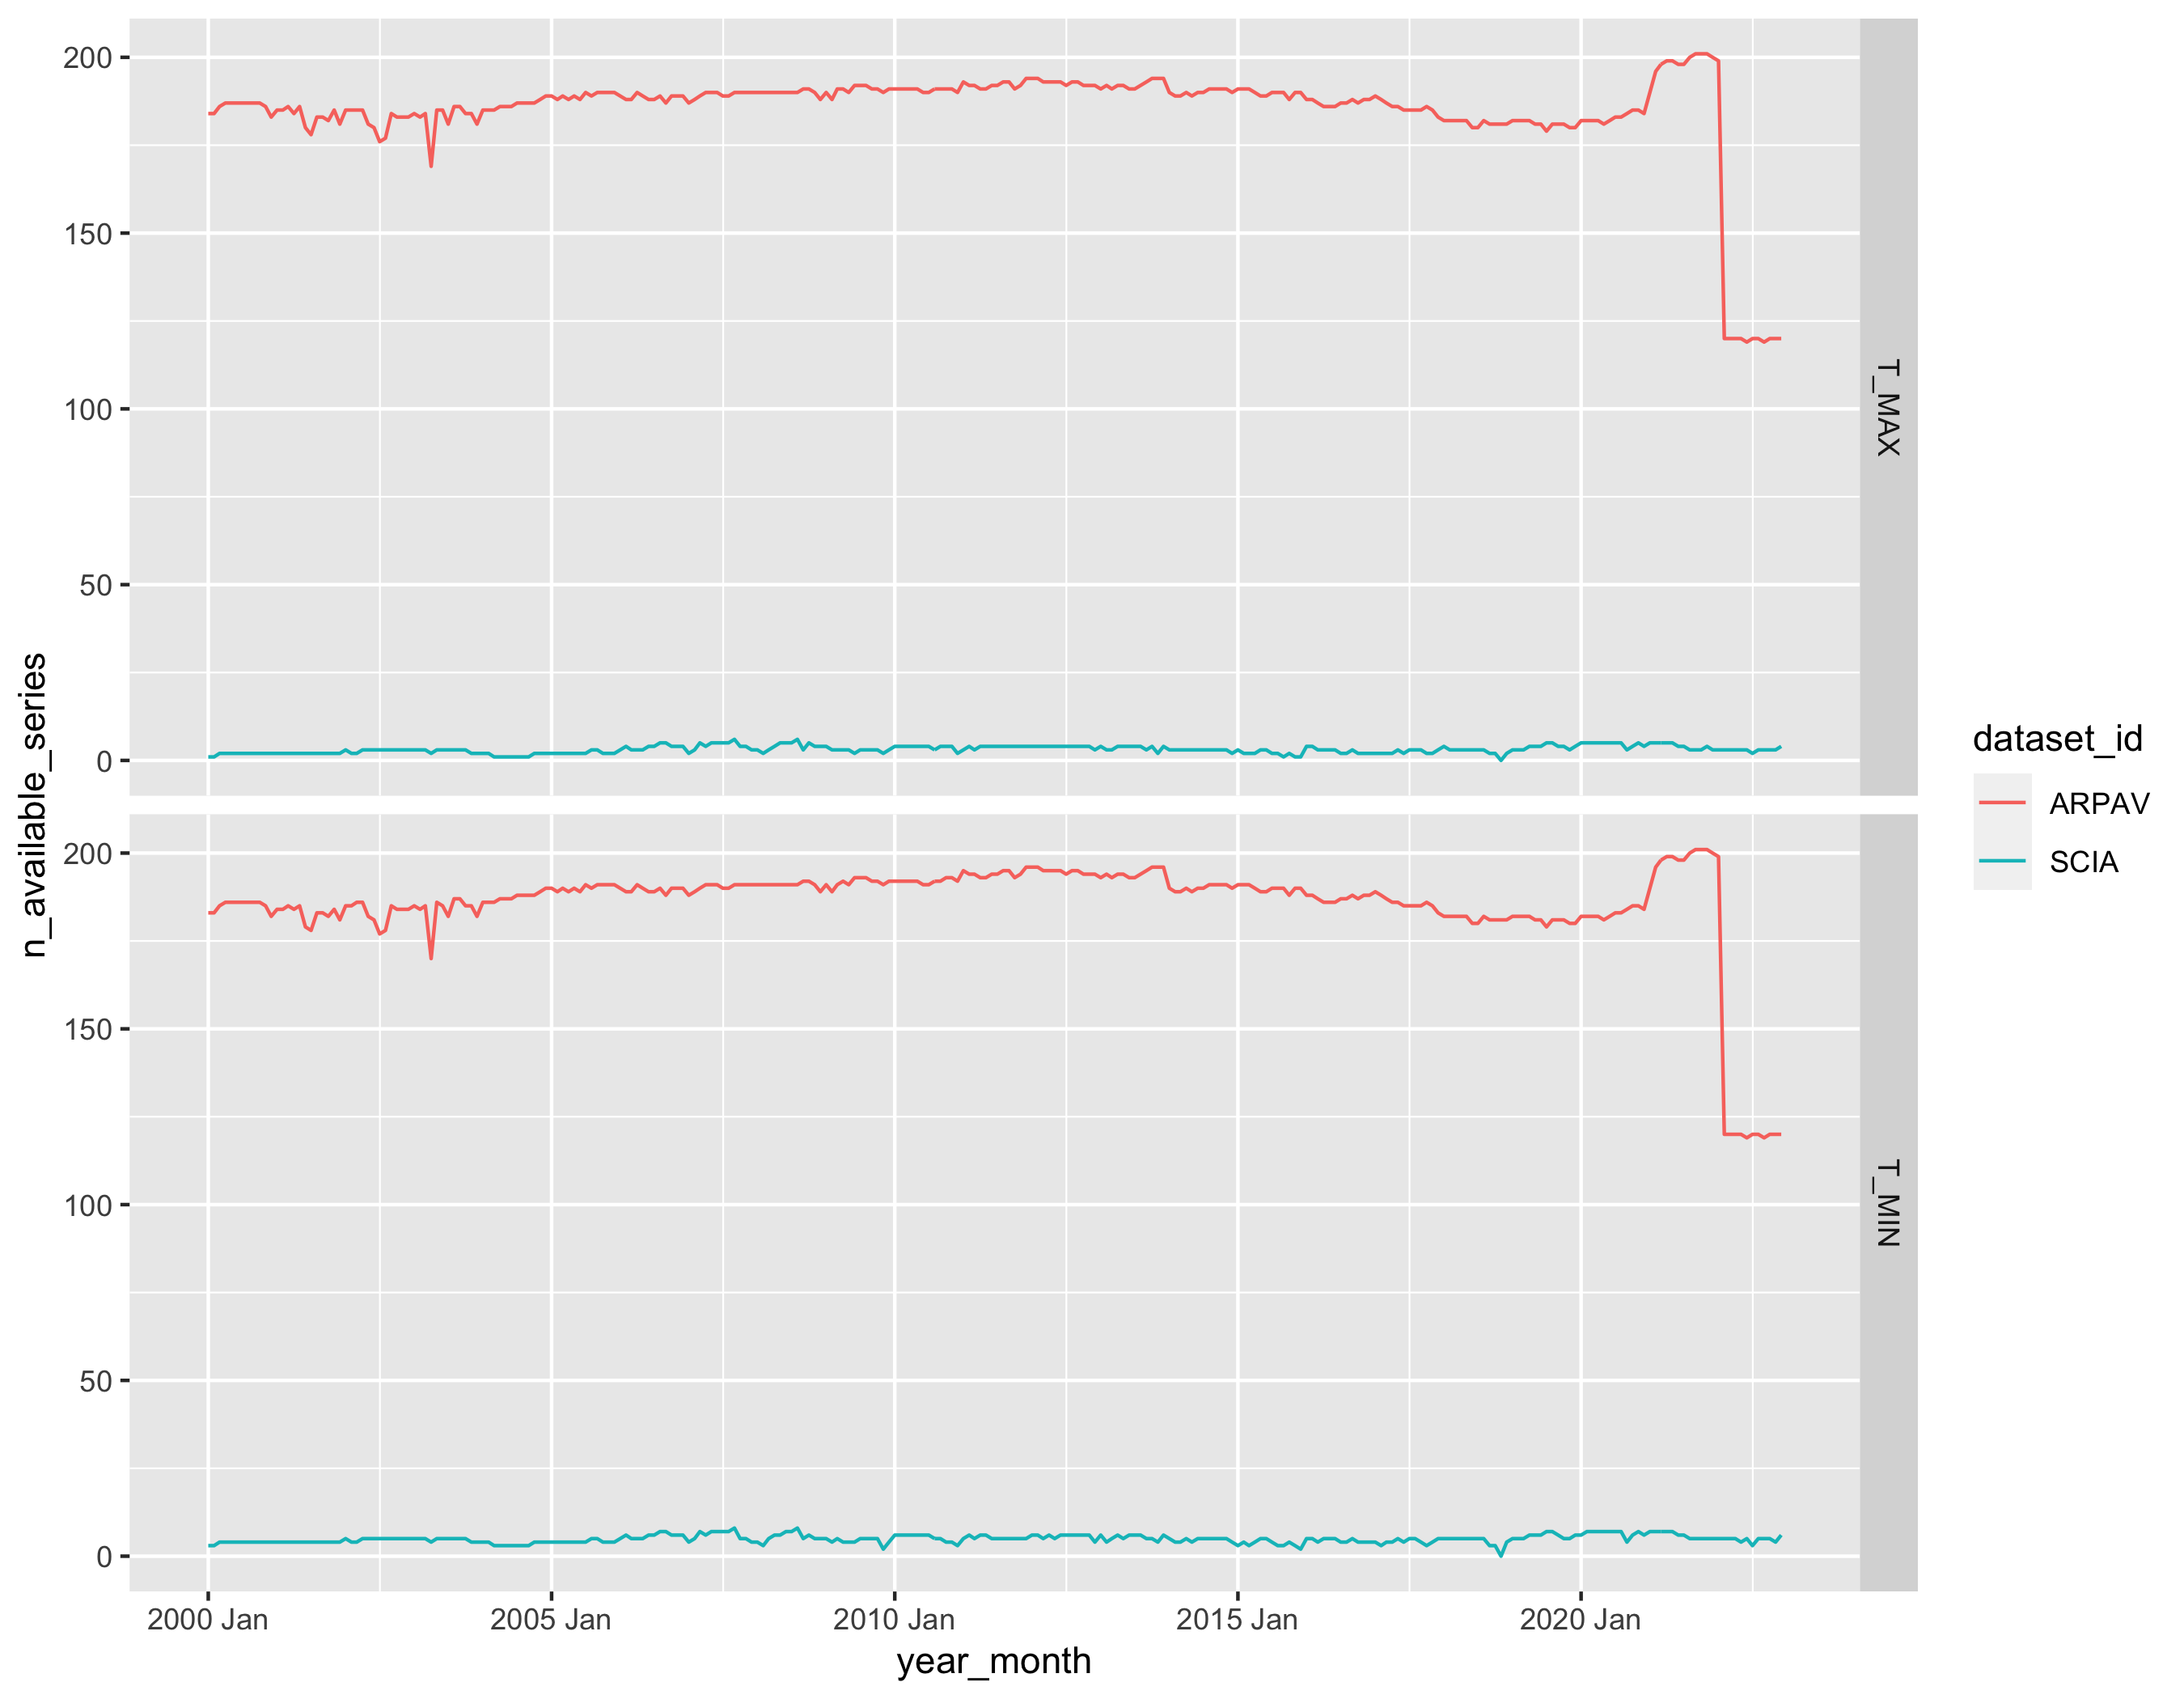

In [15]:
combined_database <- open_checkpoint(dataset_id, "scia_merged")
c(p, ymonthly_avail) %<-% ymonthly_availabilities(combined_database,
    start_date = first_date,
    end_date = last_date
)
p

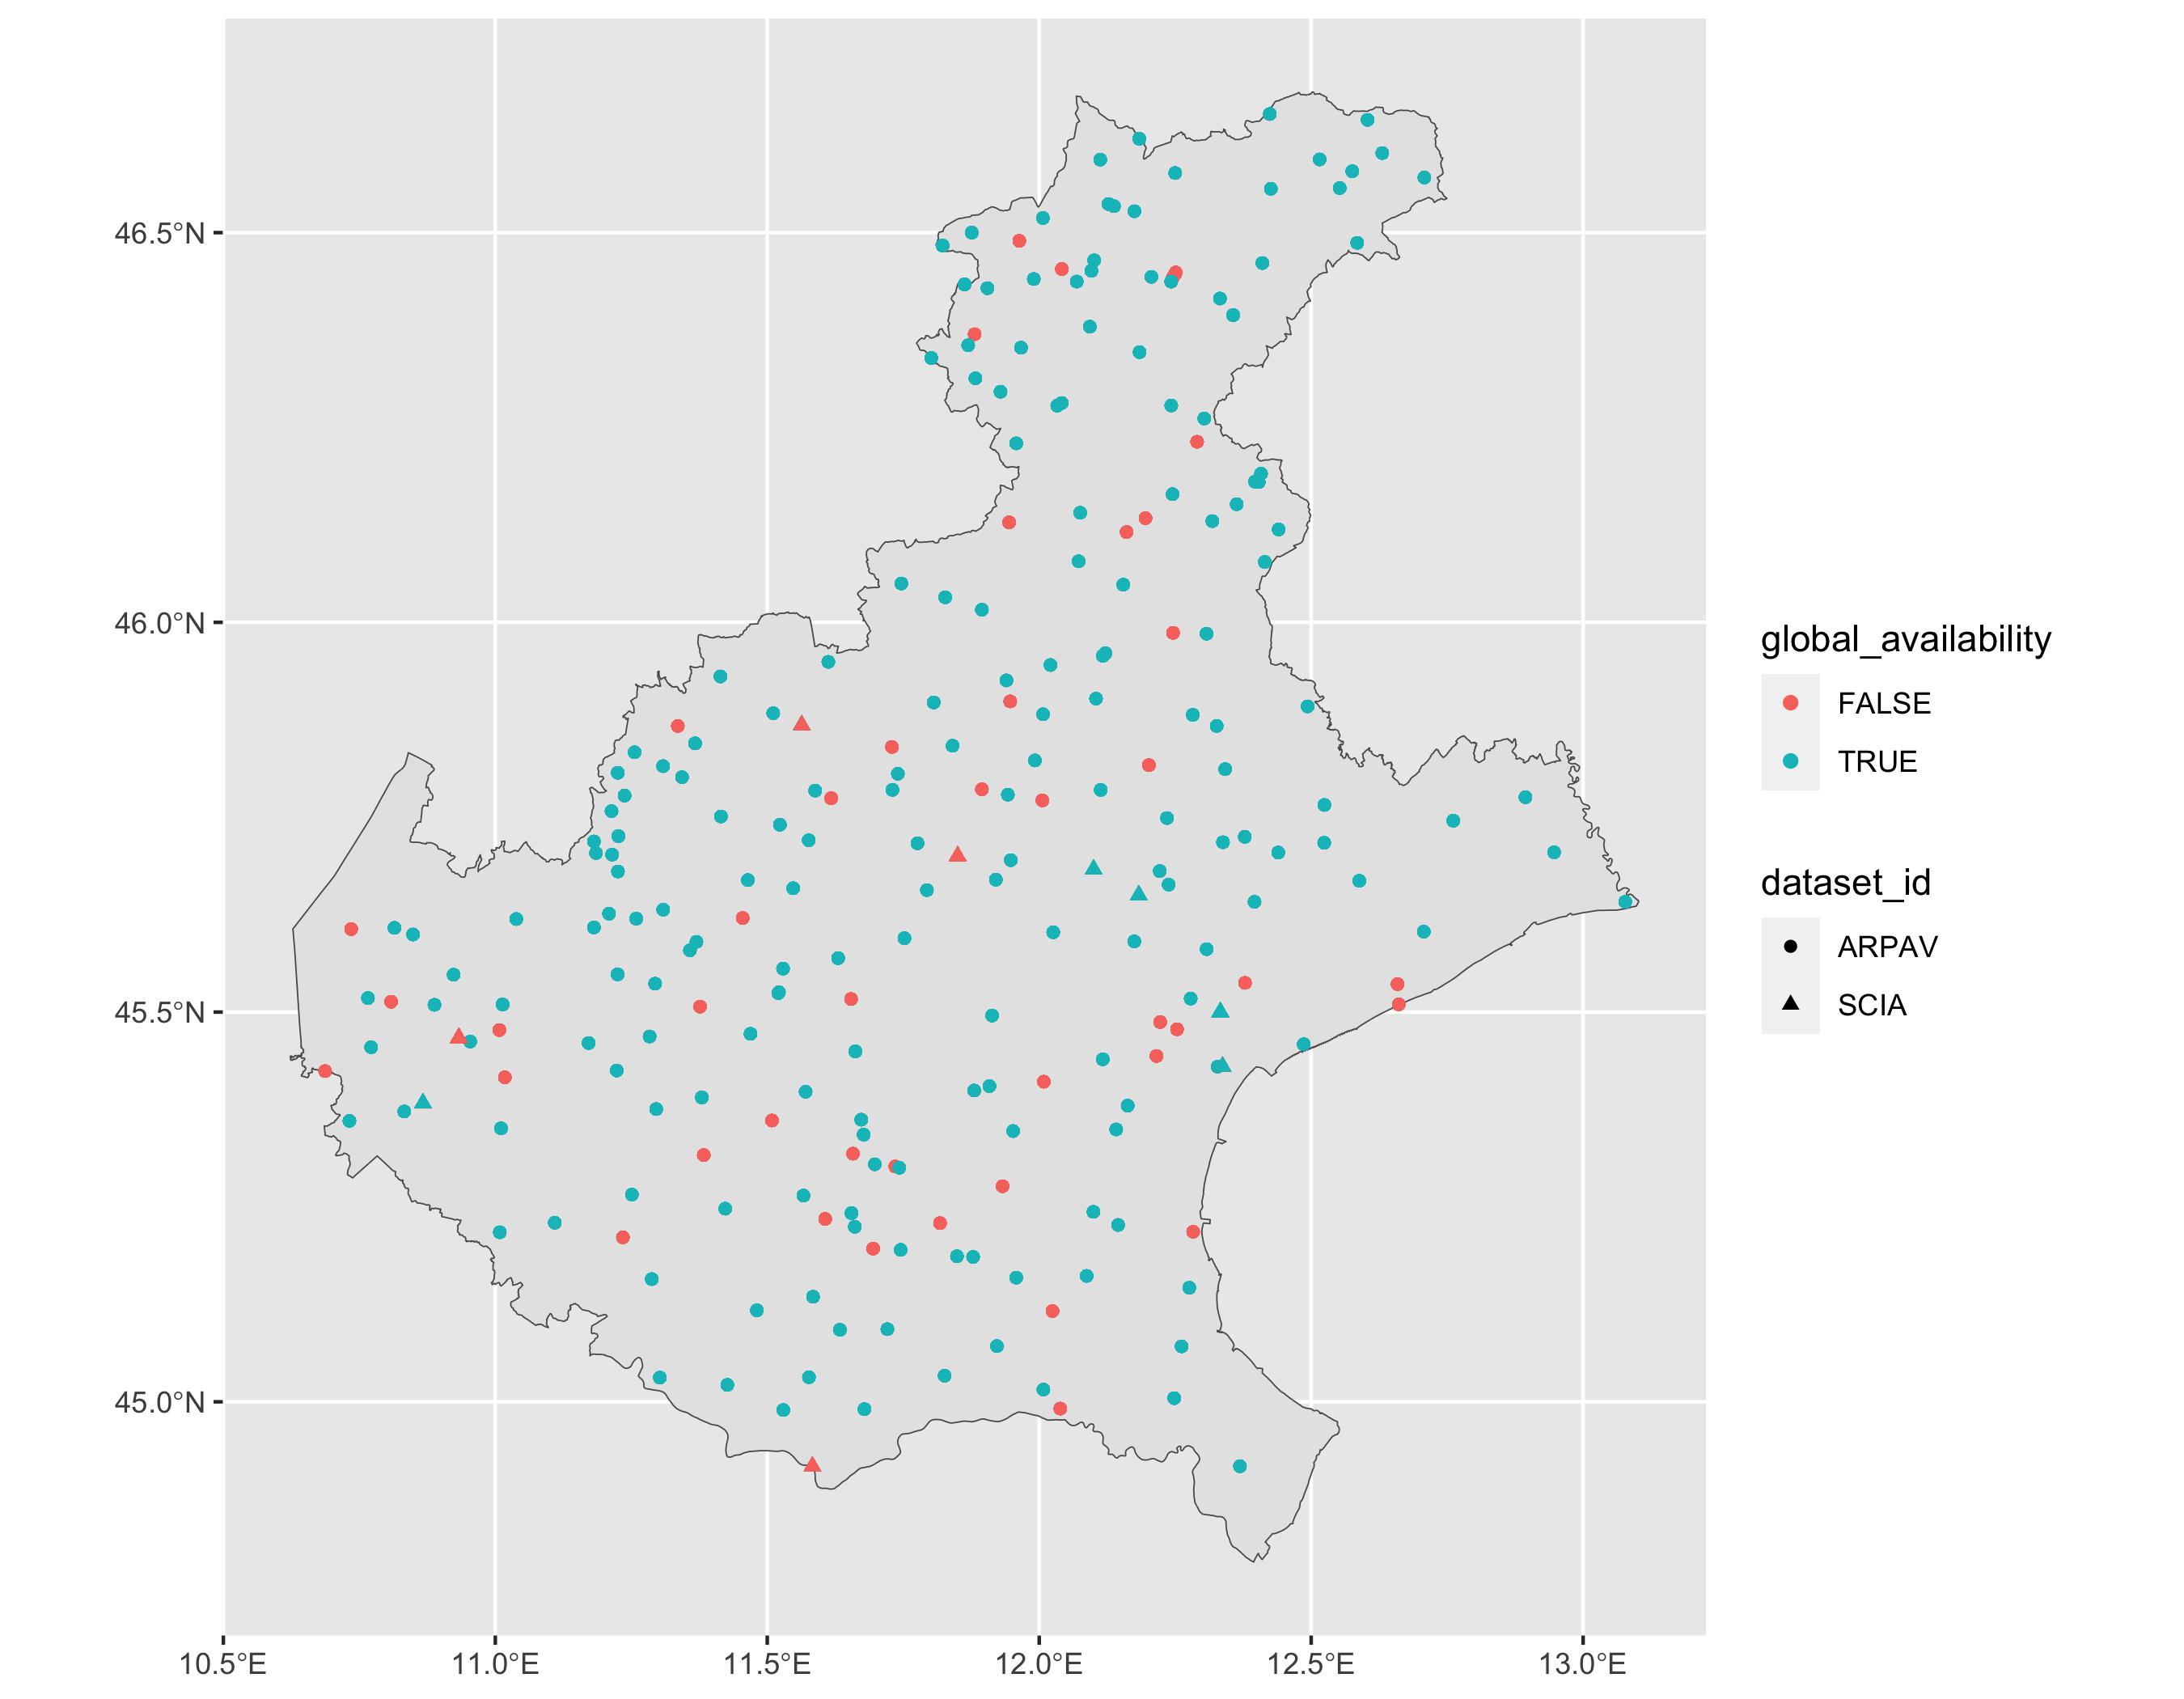

In [16]:
c(p, climats) %<-% spatial_availabilities(ymonthly_avail, combined_database$meta, state_boundaries)
p

In [18]:
rm(combined_database)
rm(combination_results)
rm(ymonthly_avail)
rm(climats)
gc()

,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2332677,124.6,6768103,361.5,NA,8460128,451.9
Vcells,20247693,154.5,513675891,3919.1,16384,802618578,6123.5


#### Merge interno

In [19]:
scia_merged <- open_checkpoint(dataset_id, "scia_merged")
analysis_results <- perform_analysis_single(
    scia_merged,
    dist_km = 4,
    first_date,
    last_date,
    file.path(str_to_lower(state), "internal.xlsx"),
)

rm(scia_merged)
gc()


Data prepared. Launching analysis...

,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2366547,126.4,6768103,361.5,NA,8460128,451.9
Vcells,7004709,53.5,410940713,3135.3,16384,802618578,6123.5


In [22]:
analysis_results <- tag_analysis(analysis_results, list("same_station" = tag_same_station_internal, "unusable" = tag_unusable_internal))
analysis_results$analysis |>
        group_by(same_station, unusable) |>
        tally()
filter(analysis_results$analysis, same_station) |>
        group_by(station_id.x) |>
        tally() |>
        filter(n > 4L | n < 2L)
filter(analysis_results$analysis, same_station) |>
        group_by(station_id.y) |>
        tally() |>
        filter(n != 2L)


same_station,unusable,n
<lgl>,<lgl>,<int>
FALSE,FALSE,108
FALSE,TRUE,128
TRUE,FALSE,68
TRUE,TRUE,12


station_id.x,n
<chr>,<int>
1cc4a6676ef5b4c5a294cfb54b536517,1
1e2c3cea9dd1d9d7fcea408bef47f3b7,1
32666336ee6816bfeb94b4388ea3d442,1
3a42e6eedc9f3dd5bd7fe90560d3319f,1
3ee40b99389d2130b2802e6ffc5c7087,1
518b92b5b90e0d099d8f6b42ca916a5e,1
6f877ccf7c84d3d69370a778216829fd,1
7068ce2467ebcef3441dca2c000a7635,1
725693eccb797eb01d2115f108758ba9,1


station_id.y,n
<chr>,<int>
1cc4a6676ef5b4c5a294cfb54b536517,1
1e2c3cea9dd1d9d7fcea408bef47f3b7,1
32666336ee6816bfeb94b4388ea3d442,1
3a42e6eedc9f3dd5bd7fe90560d3319f,1
3ee40b99389d2130b2802e6ffc5c7087,1
439e28a17801f2fa80965c0f65c1f778,3
518b92b5b90e0d099d8f6b42ca916a5e,1
578f39bdac30717abf9f6fa895384cfb,4
6686b31c6bcebee8e9494e14ffc68fb0,3


In [26]:
combination_results <- build_combined_database(analysis_results, use_corrections = TRUE, checks = TRUE, test_bounds = 2, NULL)
checkpoint_database(combination_results$database, dataset_id, "merged")
save_match_list(combination_results$match_list, dataset_id, "merged")
rm(combination_results)
rm(analysis_results)

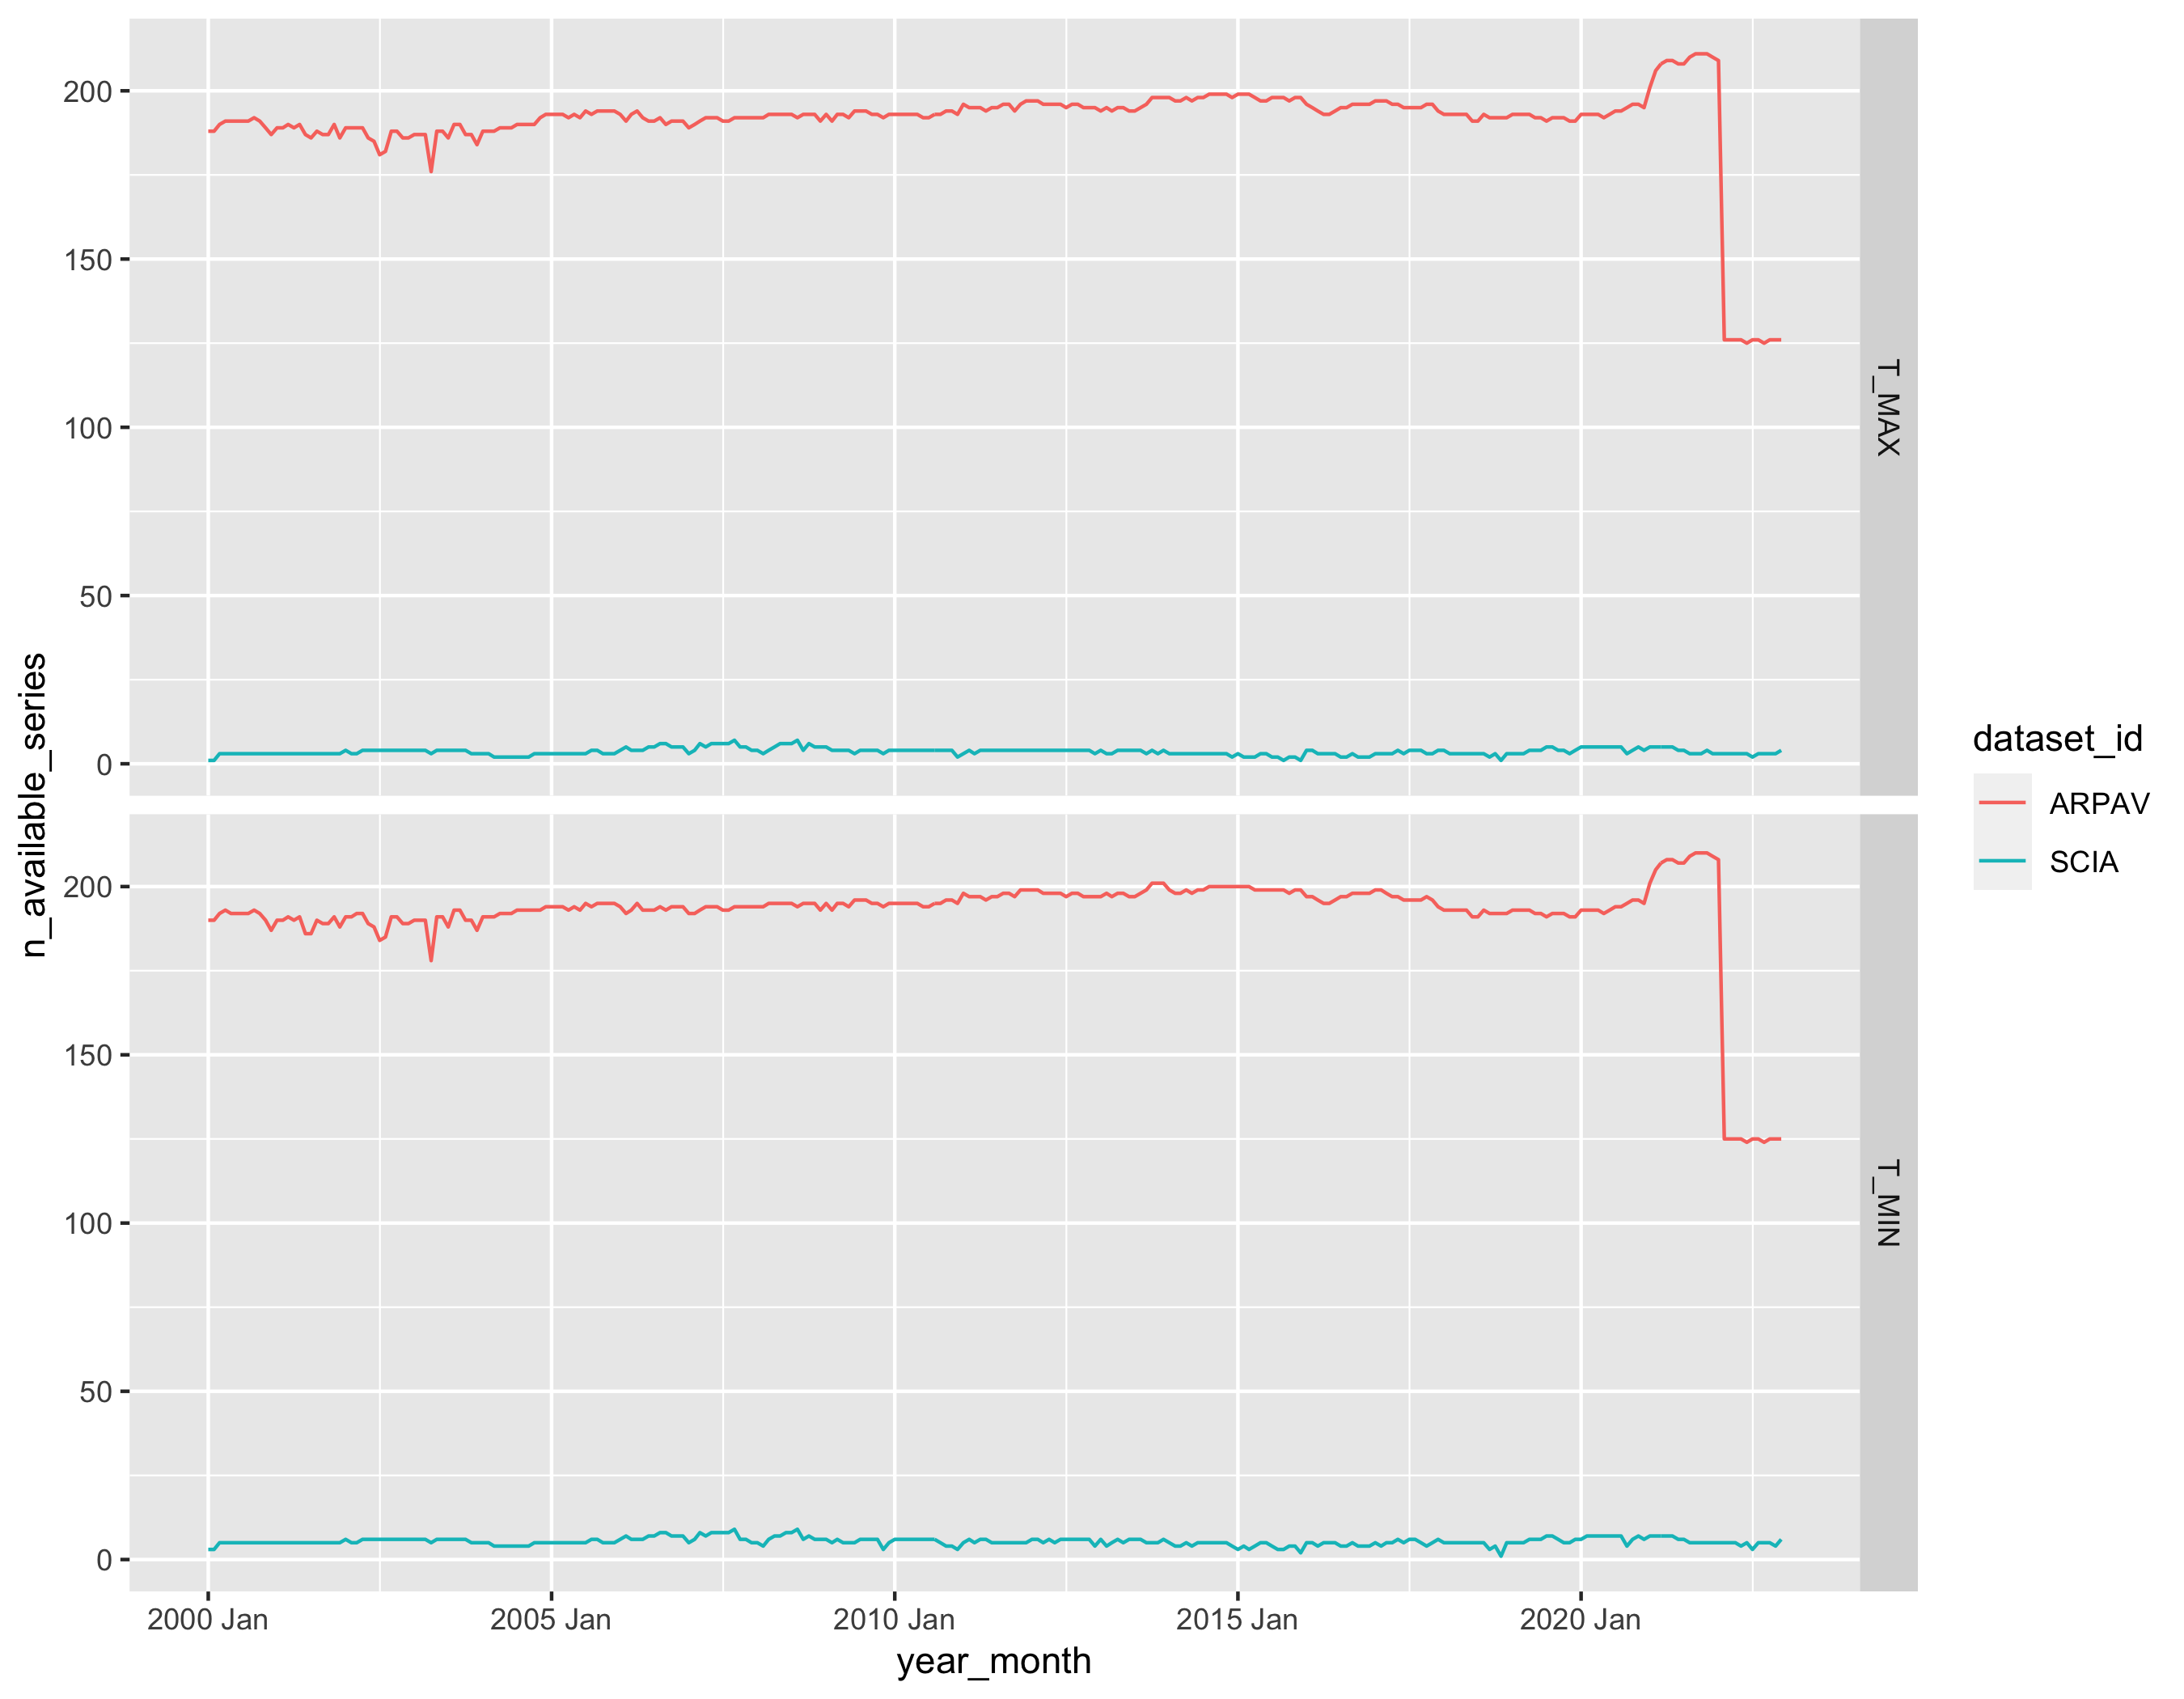

In [27]:
combined_database <- open_checkpoint(dataset_id, "merged")
c(p, ymonthly_avail) %<-% ymonthly_availabilities(combined_database,
    start_date = first_date,
    end_date = last_date
)
p

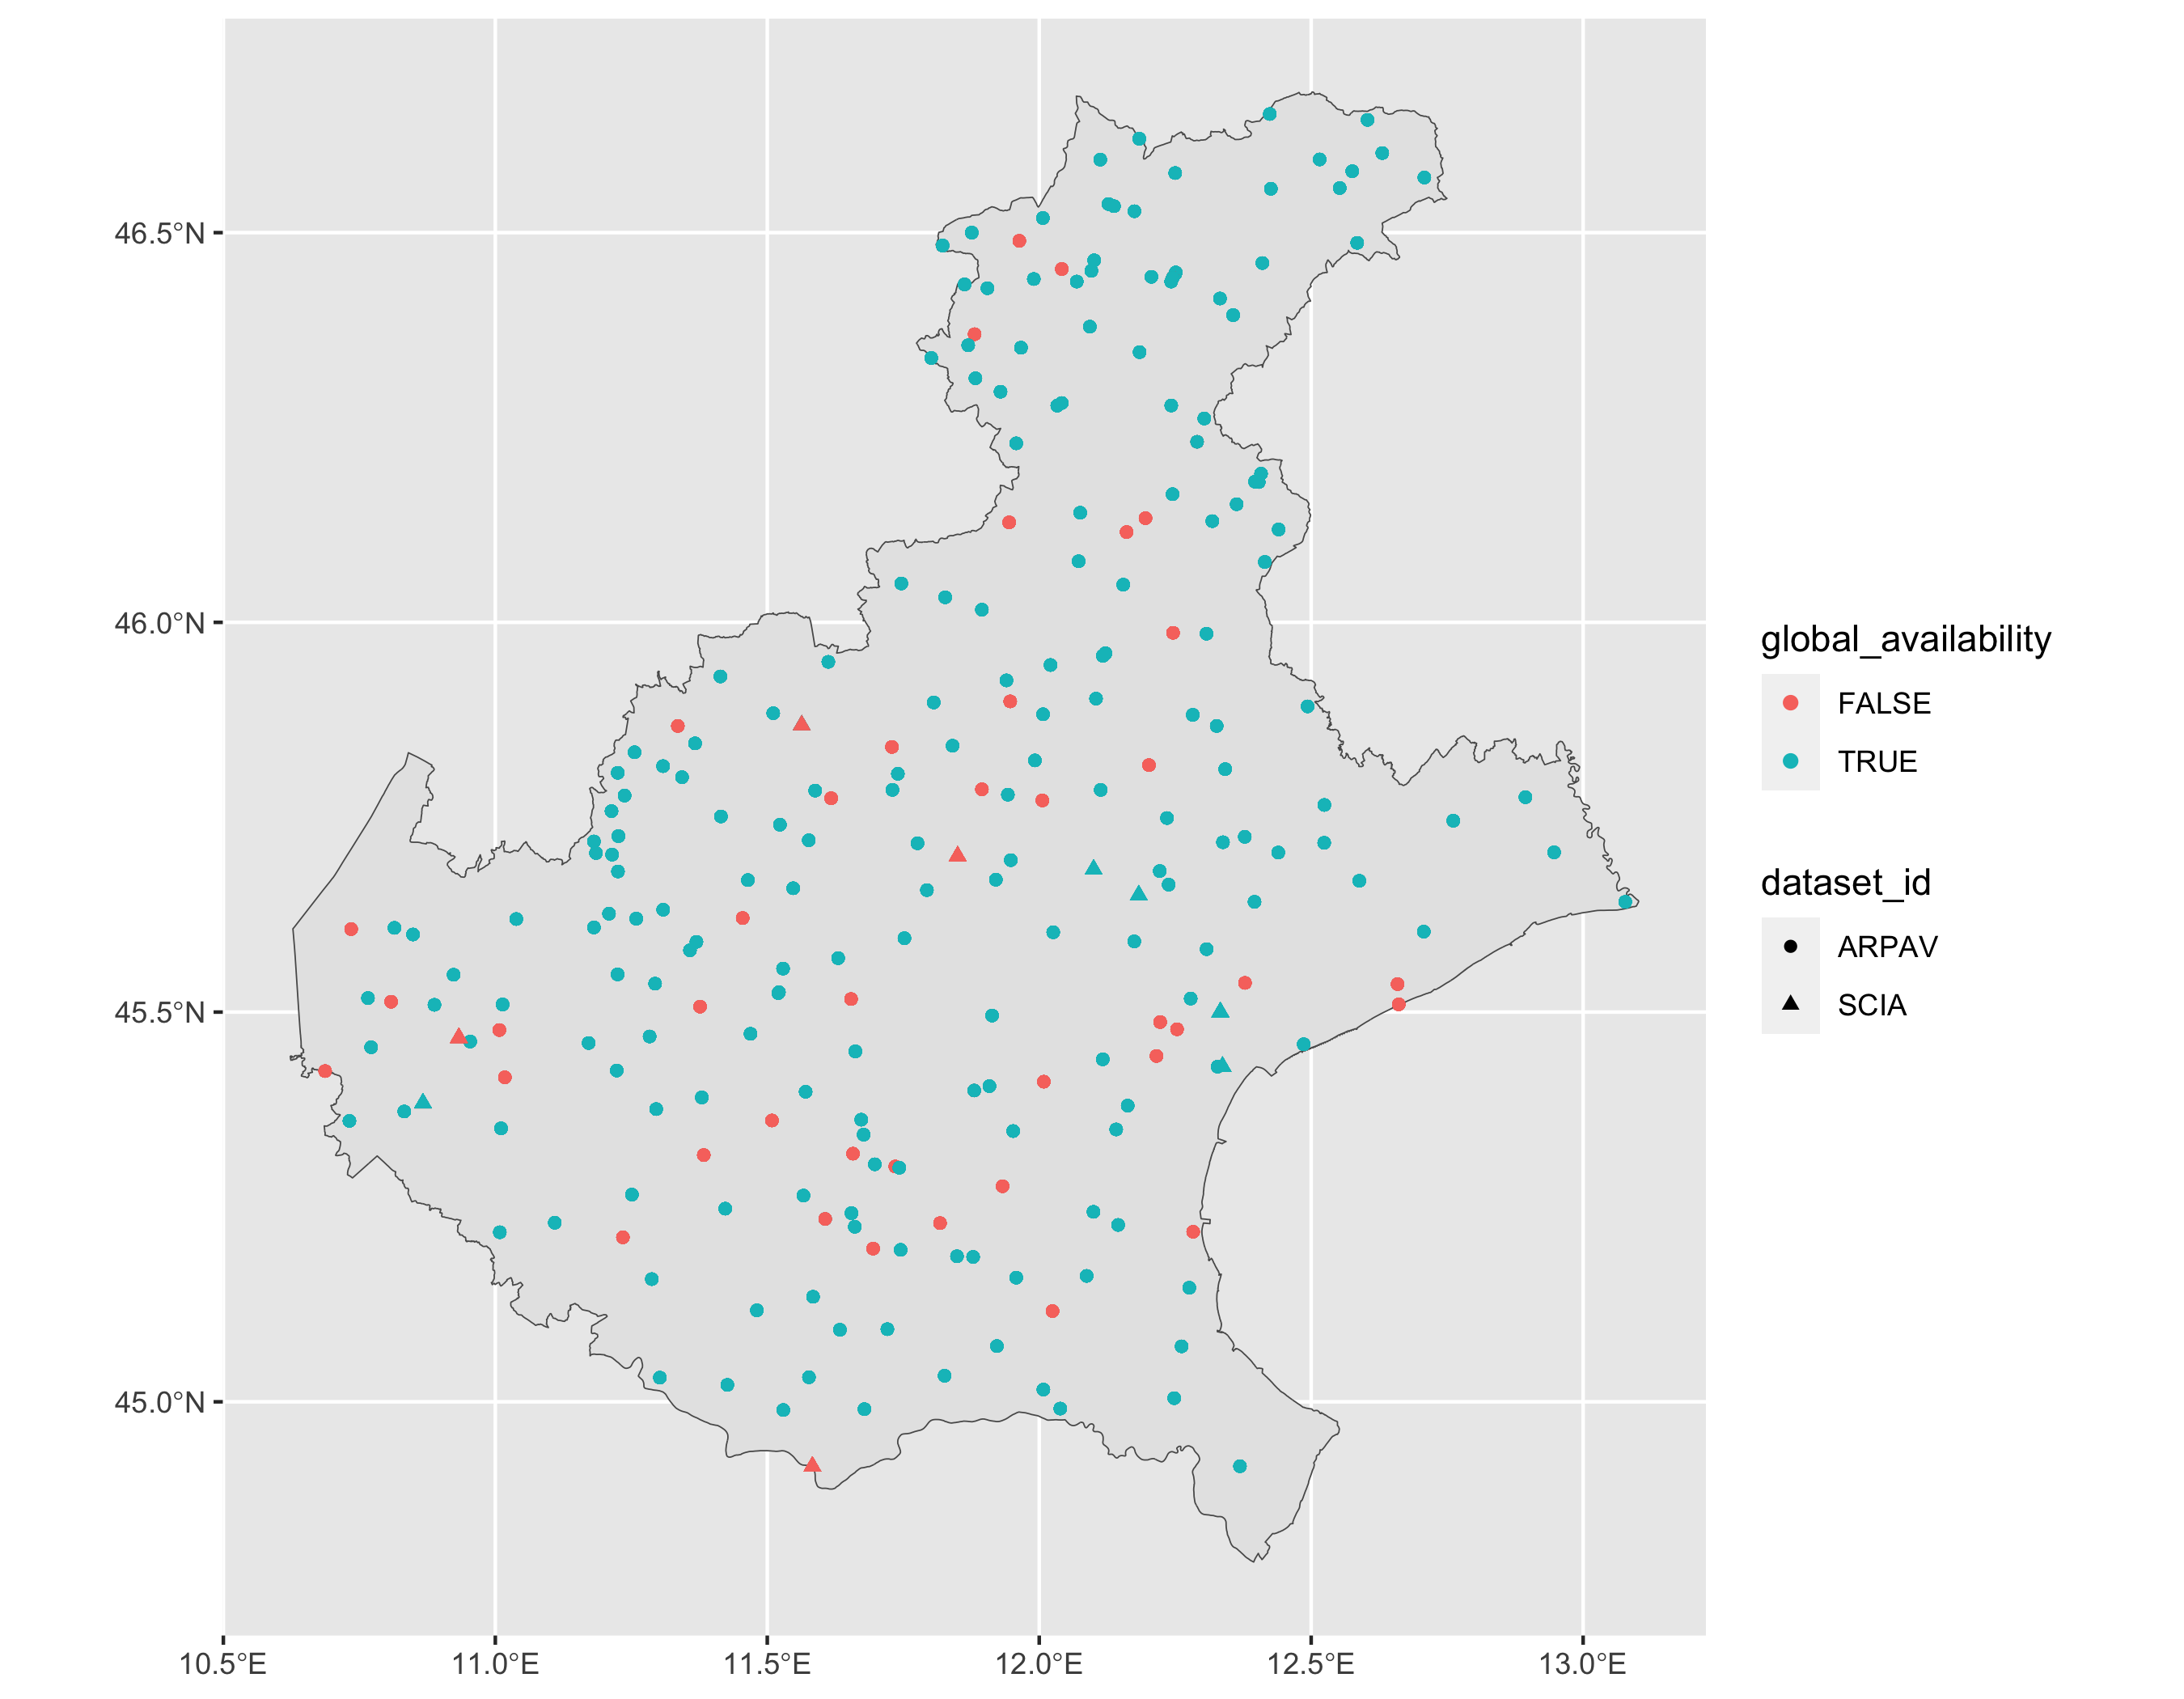

In [28]:
c(p, climats) %<-% spatial_availabilities(ymonthly_avail, combined_database$meta, state_boundaries)
p

In [29]:
combined_database$data |> distinct(station_id, variable) |> compute() |> nrow()

[1] 498

In [ ]:
source("src/pairing/displaying.R")
source("notebooks/integrazioni_regionali/procedure/checkpoint.R")
open_checkpoint("ARPAV", "qc1") |>
    launch_leaflet()